In [11]:
# Import necessary libraries
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation, SegformerImageProcessor
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, AutoProcessor
from transformers import DetrImageProcessor, DetrForObjectDetection
from ultralytics import YOLO
import numpy as np
import cv2
import requests

In [10]:
# Load the models and processors

# 0. places365 model
places_model = models.resnet18(num_classes=365)
checkpoint = torch.utils.model_zoo.load_url('http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar', map_location=torch.device('cpu'))
state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint['state_dict'].items()}
places_model.load_state_dict(state_dict)
places_model.eval()

# 1. Finetuned SegFormer for sidewalks - https://huggingface.co/nickmuchi/segformer-b4-finetuned-segments-sidewalk
segmentation_model = SegformerForSemanticSegmentation.from_pretrained("nickmuchi/segformer-b4-finetuned-segments-sidewalk")
segmentation_processor = SegformerImageProcessor.from_pretrained("nickmuchi/segformer-b4-finetuned-segments-sidewalk")

# 2. Road condition classification - https://huggingface.co/chuuuuuuee/road_condition
classification_model = AutoModelForImageClassification.from_pretrained("chuuuuuuee/road_condition")
classification_processor = AutoProcessor.from_pretrained("chuuuuuuee/road_condition")

# 3. Fine-tuned  object detection for road traffic - https://huggingface.co/josephlyr/detr-resnet-50_finetuned_road_traffic
detection_model = DetrForObjectDetection.from_pretrained("josephlyr/detr-resnet-50_finetuned_road_traffic")
detection_processor = DetrImageProcessor.from_pretrained("josephlyr/detr-resnet-50_finetuned_road_traffic")

# 4. Detect main road signs and sub road signs - https://huggingface.co/Panoramax/detect_fr_road_signs_subsigns/tree/main
weights_path = 'detect_fr_road_signs_subsigns/best.pt'
yolo_model = YOLO(weights_path)

Note: I decided to use nickmuchi's segmentation model referenced above as opposed to iammartian0's: https://huggingface.co/iammartian0/RoadSense_High_Definition_Street_Segmentation. Both models got their data from the `semantic-sidewalk` dataset (https://huggingface.co/datasets/segments/sidewalk-semantic) but the former uses the b4-sized SegFormer as opposed to the latter's dependence on the b0-sized SegFormer. The b4-sized SegFormer uses a larger volume of data and generally performs better. 

# Prerequisites

In [69]:
def load_image(image_path):
    return Image.open(image_path).convert("RGB")

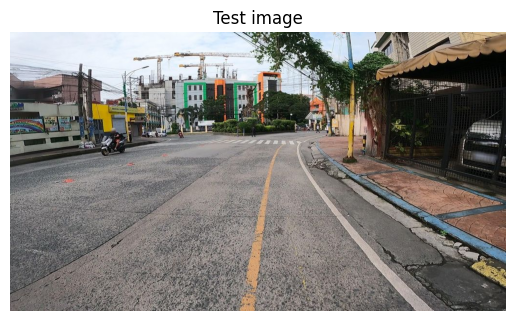

In [16]:
# Test image
image_path = "downloaded_images/6662508673859174_14.578278437308_121.03496566218.jpg"
original_image = Image.open(image_path).convert("RGB")
plt.imshow(original_image)
plt.axis('off')
plt.title('Test image')
plt.show()

In [17]:
file_path = 'sidewalk_semantic_categories.txt'
sidewalk_semantic_categories = {}

with open(file_path, 'r') as file:
    for line in file:
        parts = line.strip().split()
        key = int(parts[0])
        value = parts[1]
        sidewalk_semantic_categories[key] = value

sidewalk_semantic_categories

{0: 'unlabeled',
 1: 'flat-road',
 2: 'flat-sidewalk',
 3: 'flat-crosswalk',
 4: 'flat-cyclinglane',
 5: 'flat-parkingdriveway',
 6: 'flat-railtrack',
 7: 'flat-curb',
 8: 'human-person',
 9: 'human-rider',
 10: 'vehicle-car',
 11: 'vehicle-truck',
 12: 'vehicle-bus',
 13: 'vehicle-tramtrain',
 14: 'vehicle-motorcycle',
 15: 'vehicle-bicycle',
 16: 'vehicle-caravan',
 17: 'vehicle-cartrailer',
 18: 'construction-building',
 19: 'construction-door',
 20: 'construction-wall',
 21: 'construction-fenceguardrail',
 22: 'construction-bridge',
 23: 'construction-tunnel',
 24: 'construction-stairs',
 25: 'object-pole',
 26: 'object-trafficsign',
 27: 'object-trafficlight',
 28: 'nature-vegetation',
 29: 'nature-terrain',
 30: 'sky',
 31: 'void-ground',
 32: 'void-dynamic',
 33: 'void-static',
 34: 'void-unclear'}

# Step 1: Scene Classification using Places365

In [18]:
# Load Places365 scene categories - https://github.com/CSAILVision/places365/blob/master/categories_places365.txt
with open('categories_places365.txt') as f: 
    categories = [line.strip().split(' ')[0][3:] for line in f]

def preprocess_image_for_places365(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(image)
    return input_tensor.unsqueeze(0)  # Create a mini-batch of size 1

def is_road_image(image_path, model, categories=categories):
    input_batch = preprocess_image_for_places365(image_path)
    with torch.no_grad():
        outputs = model(input_batch)
    _, predicted = outputs.max(1)
    predicted_label = categories[predicted]
    road_related_categories = ['road', 'street', 'highway', 'alley', 'bridge', 'crosswalk', 'driveway', 'field_road', 'forest_path', 'forest_road', 'mountain_path', 'mountain_road', 'railroad_track', 'residential_neighborhood']
    return predicted_label in road_related_categories, predicted_label

In [19]:
is_road, scene_label = is_road_image(image_path, places_model, categories)
if not is_road:
    print(f"Image filtered out. Detected scene category: {scene_label}")
else:
    print(f"Image confirmed as road-related. Detected scene category: {scene_label}")

Image confirmed as road-related. Detected scene category: street


# Step 2: Segmentation using SegFormer for sidewalks

In [20]:
def segment_image(image_path, feature_extractor, segformer_model):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = segformer_model(**inputs)
    logits = outputs.logits  # (batch_size, num_classes, height, width)
    predicted_class = logits.argmax(dim=1).squeeze(0).cpu().numpy()
    return predicted_class

def visualize_segmentation(predicted_class):
    plt.imshow(predicted_class, cmap="jet")
    plt.title("Segmented Image via SegFormer for sidewalks")
    plt.axis('off')
    plt.show()

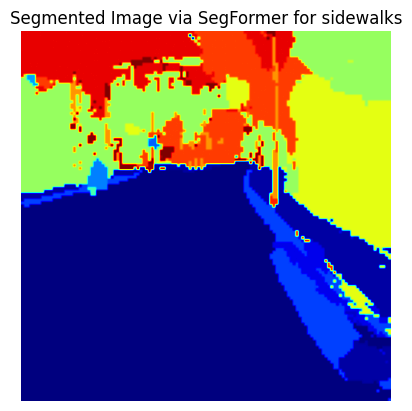

In [21]:
image_segmentation = segment_image(image_path, segmentation_processor, segmentation_model)
visualize_segmentation(image_segmentation)

In [22]:
categories_present = np.unique(image_segmentation).tolist()
category_labels_present = [sidewalk_semantic_categories[c] for c in categories_present]
print(category_labels_present)

['flat-road', 'flat-sidewalk', 'flat-crosswalk', 'flat-cyclinglane', 'flat-parkingdriveway', 'flat-curb', 'human-person', 'human-rider', 'vehicle-car', 'vehicle-bicycle', 'construction-building', 'construction-wall', 'construction-fenceguardrail', 'object-pole', 'object-trafficsign', 'nature-vegetation', 'nature-terrain', 'sky', 'void-ground', 'void-dynamic', 'void-static']


# (Skipped) Step 3: Estimate Obstruction Density

In [23]:
def calculate_obstruction_density(segmentation):
    obstruction_categories = {
        8, 9, 10, 11, 12, 13, 14, 15, 16, 17,  # Humans and Vehicles
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27  # Construction and Objects
    }
    obstruction_pixels = np.isin(segmentation, list(obstruction_categories)).sum()
    total_pixels = segmentation.size

    obstruction_density = obstruction_pixels / total_pixels
    return obstruction_density

In [24]:
calculate_obstruction_density(image_segmentation)

0.28179931640625

# (Skipped) Step 4: Estimate Other Metrics

In [25]:
def calculate_metrics(segmentation_mask, category_mapping=sidewalk_semantic_categories):

    areas = {category_mapping[i]: np.sum(segmentation_mask == i) for i in range(len(category_mapping))}
    total_area = segmentation_mask.size

    metrics = {
        'sidewalk_coverage_ratio': (
            areas['flat-sidewalk'] /
            (areas['flat-road'] + areas['flat-sidewalk'] + areas['flat-crosswalk'])
            if (areas['flat-road'] + areas['flat-sidewalk'] + areas['flat-crosswalk']) > 0
            else 0
        ),
        'protected_lane_ratio': (
            areas['flat-cyclinglane'] /
            areas['flat-road']
            if areas['flat-road'] > 0
            else 0
        ),
        'greenery_ratio': (
            (areas['nature-vegetation'] + areas['nature-terrain']) /
            total_area
        # ),
        # 'pedestrian_vehicle_interaction_score': (
        #     (areas['flat-crosswalk'] + areas['flat-sidewalk']) /
        #     (areas['flat-road'] + vehicle_count)
        #     if (areas['flat-road'] + vehicle_count) > 0
        #     else 0
        # ),
        # 'safety_infrastructure_ratio': (
        #     (areas['flat-curb'] + obstruction_count) /
        #     (areas['flat-road'] + areas['flat-sidewalk'])
        #     if (areas['flat-road'] + areas['flat-sidewalk']) > 0
        #     else 0
        # ),
        # 'vehicle_dominance_index': (
        #     vehicle_count / areas['flat-road']
        #     if areas['flat-road'] > 0
        #     else 0
        # ),
        # 'pedestrian_comfort_index': (
        #     (areas['flat-sidewalk'] + areas['nature-vegetation']) /
        #     (obstruction_count + vehicle_count)
        #     if (obstruction_count + vehicle_count) > 0
        #     else 0
        )
    }

    return metrics

In [26]:
calculate_metrics(image_segmentation)

{'sidewalk_coverage_ratio': 0.11793195302094685,
 'protected_lane_ratio': 0.03189880379485769,
 'greenery_ratio': 0.06591796875}

# Step 6: Retrieving all category contributions
Instead of deciding on how metrics would be computed, I will just compute the ratio of each category to the total number of pixels and include it in the output dataframe.

In [27]:
def get_category_contribution(segmentation_mask, category_mapping=sidewalk_semantic_categories):
    total_area = segmentation_mask.size
    areas = {category_mapping[i]: np.sum(segmentation_mask == i)/total_area for i in range(len(category_mapping))}

    return areas

In [28]:
get_category_contribution(image_segmentation)

{'unlabeled': 0.0,
 'flat-road': 0.44390869140625,
 'flat-sidewalk': 0.0594482421875,
 'flat-crosswalk': 0.000732421875,
 'flat-cyclinglane': 0.01416015625,
 'flat-parkingdriveway': 6.103515625e-05,
 'flat-railtrack': 0.0,
 'flat-curb': 0.04754638671875,
 'human-person': 0.00067138671875,
 'human-rider': 0.00360107421875,
 'vehicle-car': 0.0008544921875,
 'vehicle-truck': 0.0,
 'vehicle-bus': 0.0,
 'vehicle-tramtrain': 0.0,
 'vehicle-motorcycle': 0.0,
 'vehicle-bicycle': 0.00042724609375,
 'vehicle-caravan': 0.0,
 'vehicle-cartrailer': 0.0,
 'construction-building': 0.1534423828125,
 'construction-door': 0.0,
 'construction-wall': 0.00042724609375,
 'construction-fenceguardrail': 0.10992431640625,
 'construction-bridge': 0.0,
 'construction-tunnel': 0.0,
 'construction-stairs': 0.0,
 'object-pole': 0.0123291015625,
 'object-trafficsign': 0.0001220703125,
 'object-trafficlight': 0.0,
 'nature-vegetation': 0.06475830078125,
 'nature-terrain': 0.00115966796875,
 'sky': 0.0758056640625,
 '

# Step 5: Determine road quality

In [29]:
def extract_road(image, segmentation, class_ids=[1], display_image=False):
    # Ensure the segmentation mask matches the size of the original image
    segmentation_resized = Image.fromarray(segmentation.astype(np.uint8)).resize(image.size, resample=Image.NEAREST)
    segmentation_resized = np.array(segmentation_resized)

    sidewalk_mask = np.isin(segmentation_resized, class_ids)
    image_array = np.array(image, dtype=np.uint8)

    image_array[~sidewalk_mask] = [255, 255, 255]
    extracted_image = Image.fromarray(image_array)

    if display_image:
        plt.imshow(extracted_image)
        plt.axis('off')
        plt.show()
    
    return extracted_image

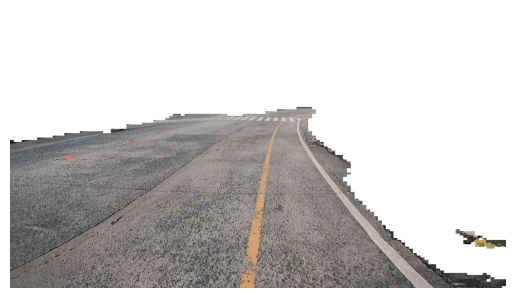

In [30]:
extracted_road = extract_road(original_image, image_segmentation, display_image=True)

In [31]:
def classify_road_condition(image):
    inputs = classification_processor(images=image, return_tensors="pt")
    outputs = classification_model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(predictions).item()
    road_condition = "good" if predicted_class == 1 else "bad"
    return road_condition

In [32]:
good_road = Image.open('good_road.jpg').convert("RGB")
# classify_road_condition(good_road)
# classify_road_condition(extracted_road)
classify_road_condition(extracted_road)

'bad'

# Step 6: Object Detection

In [33]:
def detect_traffic_objects(image):
    inputs = detection_processor(images=image, return_tensors="pt")

    outputs = detection_model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])  # Target size in (height, width) format
    results = detection_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

    detected_objects = []

    if 'scores' in results and 'labels' in results and 'boxes' in results:
        for score, label, box in zip(results['scores'], results['labels'], results['boxes']):
            # Use the model's label map to get the class name from the label ID
            class_name = detection_model.config.id2label[label.item()]
            score_value = score.item()
            detected_objects.append({"label": class_name, "score": score_value, "box": box.tolist()})
    else:
        print("Expected keys ('scores', 'labels', 'boxes') not found in the results.")

    return list(set([c['label'] for c in detected_objects]))

In [34]:
detect_traffic_objects(original_image)

['motorcycles']

In [78]:
def detect_traffic_signs(image):
    results = yolo_model(image,verbose=True)

    detected_traffic_signs = []
    for result in results:
        for box in result.boxes:
            label = box.cls  # Object class ID
            score = box.conf.item()  # Confidence score
            bbox = box.xyxy[0].tolist()  # Bounding box coordinates

            detected_traffic_signs.append({'label': yolo_model.names[int(label)], 'bbox': bbox, 'score': score})
    return detected_traffic_signs


In [87]:
detect_traffic_signs(load_image('sign-test.jpg'))


0: 320x224 1 panneau, 1 panonceau, 283.8ms
Speed: 2.5ms preprocess, 283.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 224)


[{'label': 'panneau',
  'bbox': [53.67014694213867,
   58.17306137084961,
   211.09115600585938,
   235.49537658691406],
  'score': 0.8374877572059631},
 {'label': 'panonceau',
  'bbox': [37.80799865722656,
   267.82147216796875,
   242.9953155517578,
   324.2301330566406],
  'score': 0.6823750138282776}]

# Putting it all together (Pipeline)

In [58]:
def process_image(image_path, print_values=True, class_ids=[1]):
    
    # Determine if the image is usable
    is_road, scene_label = is_road_image(image_path, places_model, categories)
    
    if is_road:
        # Open image
        image = Image.open(image_path).convert("RGB")
        
        # Segment image
        image_segmentation = segment_image(image_path, segmentation_processor, segmentation_model)
        
        # Determine categories
        categories_present = np.unique(image_segmentation).tolist()
        category_labels_present = [sidewalk_semantic_categories[c] for c in categories_present]

        # Metrics
        # obstruction_density = calculate_obstruction_density(image_segmentation)
        # additional_metrics = calculate_metrics(image_segmentation)
        category_contributions = get_category_contribution(image_segmentation)

        # Road quality
        extracted_road = extract_road(image, image_segmentation, class_ids=class_ids)
        road_condition = classify_road_condition(extracted_road)

        # Traffic objects and traffic signs
        traffic_objects = detect_traffic_objects(image)
        traffic_signs = detect_traffic_signs(image)


#         if print_values:
#             visualize_segmentation(image_segmentation)
#             print(f"""Category labels present: {category_labels_present}\n\n
# Obstruction density: {obstruction_density}\n
# Sidewalk coverage ratio: {additional_metrics['sidewalk_coverage_ratio']}\n
# Protected lane ratio: {additional_metrics['protected_lane_ratio']}\n
# Greenery ratio: {additional_metrics['greenery_ratio']}\n
# Road condition: {road_condition}\n\n
# Detected objects: {detected_objects}""")

        if print_values:
            
            plt.imshow(image)
            plt.axis('off')
            plt.title('Test image')
            plt.show()
            
            visualize_segmentation(image_segmentation)
            print(f"""Category labels present: {category_labels_present}\n\n
Scene label: {scene_label}\n\n
Road condition: {road_condition}\n\n
Detected traffic objects: {traffic_objects}\n\n""")
            print('Detected traffic signs')
            print(traffic_signs)
            print('\n')
            print('\n\nCategory contributions:\n')
            for k,v in category_contributions.items():
                if v != 0:
                    print(f"{k}: {round(v,4)}")

        output = {
            'scene_label' : scene_label,
            'elements_present' : category_labels_present,
            'road_condition' : road_condition,
            'traffic_objects' : traffic_objects,
            # 'general_objects' : general_objects
            # 'obstruction_density' : obstruction_density
        # }.update(additional_metrics)
        }.update(category_contributions)

        print('\n-----\nImage is usable and has been successfully processed.')
        return output
        
    else:
        print('Image is not usable.')

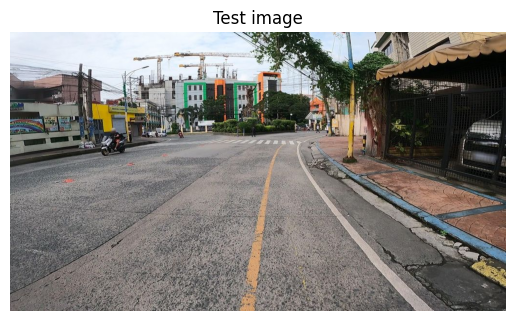

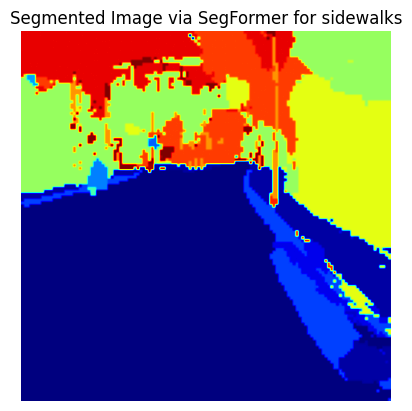

Category labels present: ['flat-road', 'flat-sidewalk', 'flat-crosswalk', 'flat-cyclinglane', 'flat-parkingdriveway', 'flat-curb', 'human-person', 'human-rider', 'vehicle-car', 'vehicle-bicycle', 'construction-building', 'construction-wall', 'construction-fenceguardrail', 'object-pole', 'object-trafficsign', 'nature-vegetation', 'nature-terrain', 'sky', 'void-ground', 'void-dynamic', 'void-static']


Scene label: street


Road condition: bad


Detected traffic objects: ['motorcycles']


Detected traffic signs
[]




Category contributions:

flat-road: 0.4439
flat-sidewalk: 0.0594
flat-crosswalk: 0.0007
flat-cyclinglane: 0.0142
flat-parkingdriveway: 0.0001
flat-curb: 0.0475
human-person: 0.0007
human-rider: 0.0036
vehicle-car: 0.0009
vehicle-bicycle: 0.0004
construction-building: 0.1534
construction-wall: 0.0004
construction-fenceguardrail: 0.1099
object-pole: 0.0123
object-trafficsign: 0.0001
nature-vegetation: 0.0648
nature-terrain: 0.0012
sky: 0.0758
void-ground: 0.0001
void-dynamic:

In [59]:
image_path = "downloaded_images/6662508673859174_14.578278437308_121.03496566218.jpg"
process_image(image_path)

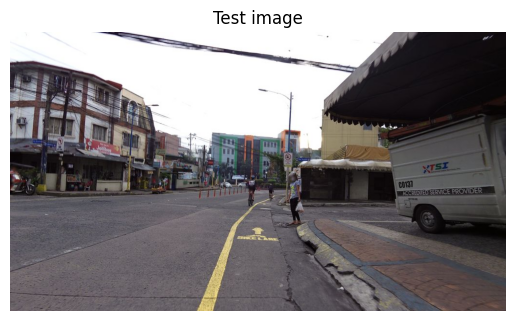

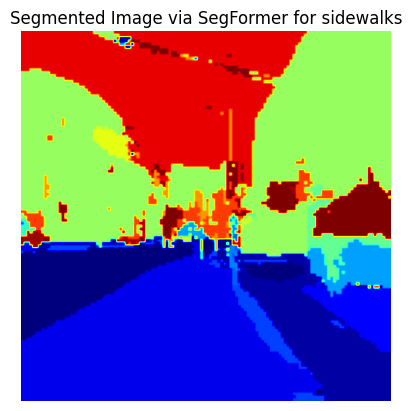

Category labels present: ['flat-road', 'flat-sidewalk', 'flat-crosswalk', 'flat-cyclinglane', 'flat-parkingdriveway', 'flat-curb', 'human-person', 'human-rider', 'vehicle-car', 'vehicle-motorcycle', 'vehicle-bicycle', 'vehicle-caravan', 'construction-building', 'construction-wall', 'construction-fenceguardrail', 'object-pole', 'object-trafficsign', 'nature-vegetation', 'nature-terrain', 'sky', 'void-dynamic', 'void-static']


Scene label: street


Road condition: good


Detected traffic objects: []


Detected traffic signs
[]




Category contributions:

flat-road: 0.0682
flat-sidewalk: 0.0777
flat-crosswalk: 0.0005
flat-cyclinglane: 0.2066
flat-parkingdriveway: 0.024
flat-curb: 0.0184
human-person: 0.0014
human-rider: 0.0017
vehicle-car: 0.0224
vehicle-motorcycle: 0.0009
vehicle-bicycle: 0.0005
vehicle-caravan: 0.0137
construction-building: 0.302
construction-wall: 0.0015
construction-fenceguardrail: 0.0057
object-pole: 0.0085
object-trafficsign: 0.0001
nature-vegetation: 0.0188
natur

In [60]:
image_path = "downloaded_images/2922512717961772_14.578411111111_121.03526944444.jpg"
process_image(image_path)

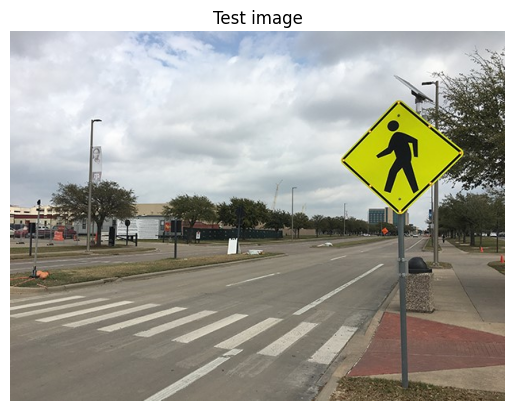

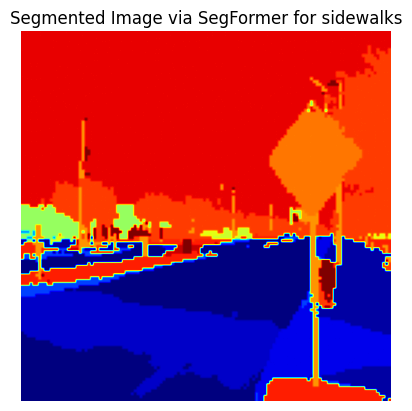

Category labels present: ['flat-road', 'flat-sidewalk', 'flat-crosswalk', 'flat-cyclinglane', 'flat-parkingdriveway', 'flat-curb', 'vehicle-car', 'construction-building', 'construction-wall', 'construction-fenceguardrail', 'object-pole', 'object-trafficsign', 'object-trafficlight', 'nature-vegetation', 'nature-terrain', 'sky', 'void-ground', 'void-static']


Scene label: crosswalk


Road condition: good


Detected traffic objects: ['crosswalks']


Detected traffic signs
[]




Category contributions:

flat-road: 0.1625
flat-sidewalk: 0.0472
flat-crosswalk: 0.1078
flat-cyclinglane: 0.046
flat-parkingdriveway: 0.0005
flat-curb: 0.0124
vehicle-car: 0.0005
construction-building: 0.0171
construction-wall: 0.002
construction-fenceguardrail: 0.0019
object-pole: 0.0244
object-trafficsign: 0.0433
object-trafficlight: 0.0001
nature-vegetation: 0.1121
nature-terrain: 0.0405
sky: 0.3705
void-ground: 0.0019
void-static: 0.0096

-----
Image is usable and has been successfully processed.


In [61]:
image_path = "pedestrian-test.jpg"
process_image(image_path)

Based on the last processed image, both object detection models cannot detect traffic signs. My suggestion is to use the `object-trafficsign` category from the image segmentation. For example, if the contribution of this category exceeds a set threshold, say `0.002`, then we can consider the image to have a traffic sign. Currently, I cannot utilize a huggingface 